In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.applications as apps

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
;

2023-06-23 09:20:38.256824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 09:20:38.358545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2023-06-23 09:20:38.358561: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-23 09:20:38.894509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object

''

In [2]:
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    letras = []
    for filename in os.listdir(folder):
        letras.append(filename[0])
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return (images, letras)

In [3]:
images = []
letras = []
for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/Nosso Dataset/')[0]:
    images.append(image)

for letra in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/Nosso Dataset/')[1]:
    letras.append(letra)

In [4]:
print(letras)

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'N', 'N', 'N', 'N', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'P', 'P', 'P', 'P', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'R', 'R', 'R', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'B', 'D', 'E', 'G', 'L', 'L', 'N', 'P', 'R', 'U', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'L', 'L', 'L', 'L',

In [5]:
images = np.asarray(images)
from PIL import Image

print("Changing resolution ...")


X = []
for i in range(0, images.shape[0]):
    X.append(np.array(Image.fromarray(images[i]).resize(size=(64,64))))
images = np.array(X)


Changing resolution ...


/tmp/ipykernel_44501/2775639092.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


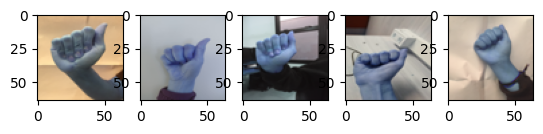

In [6]:
fig, axes = plt.subplots(1, 5)
axes[0].imshow(images[0])
axes[1].imshow(images[1])
axes[2].imshow(images[2])
axes[3].imshow(images[3])
axes[4].imshow(images[4])
plt.show()

In [7]:
def visualize(original, augmentation):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    augmented = augmentation(original)
    plt.imshow(augmented)

In [8]:
def flipImage(image):
    return tf.image.flip_left_right(image)

def ContrastImage(image):
    return np.array(tf.image.adjust_contrast(image, 2.))

def SaturateImage(image):
    return np.array(tf.image.adjust_saturation(image, 5.))

def add_salt_pepper_noise(image):
    # Need to produce a copy as to not modify the original image
    image_copy = image.copy()
    salt_vs_pepper = 0.2
    amount = 0.02
    num_salt = np.ceil(amount * image_copy.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * image_copy.size * (1.0 - salt_vs_pepper))
    
    # Add Salt noise
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_copy.shape]
    image_copy[coords[0], coords[1], :] = 255

    # Add Pepper noise
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_copy.shape]
    image_copy[coords[0], coords[1], :] = 0
    return image_copy

def apply_rotationHour20(image, degrees = 20):
    height, width = image.shape[:2]
    rotation_matrix = cv.getRotationMatrix2D((width / 2, height / 2), degrees, 1)
    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def apply_rotationAntihour20(image, degrees = -20):
    height, width = image.shape[:2]
    rotation_matrix = cv.getRotationMatrix2D((width / 2, height / 2), degrees, 1)
    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def GrayScale(image):
    return cv.cvtColor(cv.cvtColor(image, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB)

funcs = [flipImage, ContrastImage, SaturateImage, add_salt_pepper_noise, apply_rotationHour20, apply_rotationAntihour20]

In [9]:
def AugmentImage(image, funcs):
    functions = np.random.permutation(funcs)
    image1 = functions[0](image)
    image2 = functions[1](image)
    image3 = functions[2](image)
    image4 = functions[3](image)
    return image1, image2, image3, image4

In [10]:
test1, test2, test3, test4 = AugmentImage(images[0], funcs)

2023-06-23 09:22:10.810888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emanueloliveira/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-06-23 09:22:10.811789: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-23 09:22:10.812403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emanueloliveira-CI581128TBW10): /proc/driver/nvidia/version does not exist
2023-06-23 09:22:10.821922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations,

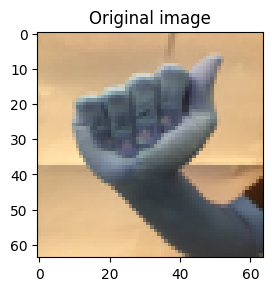

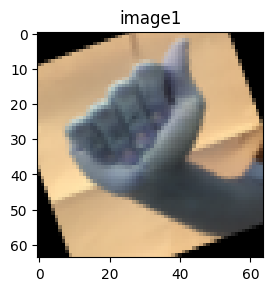

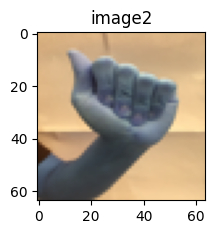

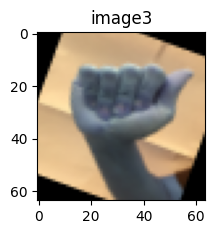

In [11]:
fig = plt.figure()
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(images[0])

fig = plt.figure()
plt.subplot(1,2,2)
plt.title('image1')
plt.imshow(test1)

fig = plt.figure()
plt.subplot(2,1,1)
plt.title('image2')
plt.imshow(test2)

fig = plt.figure()
plt.subplot(2,2,2)
plt.title('image3')
plt.imshow(test3)

In [12]:
print(images.shape)

(301, 64, 64, 3)


In [13]:
AugImages = []
LetrasAug = []
cont = 0
for img in images:
    LetrasAug.append(letras[cont])
    AugImages.append(img)
    for aug in AugmentImage(img, funcs):
        AugImages.append(aug)
        LetrasAug.append(letras[cont])
    cont += 1

In [14]:
print(np.array(AugImages).shape)

(1505, 64, 64, 3)


In [15]:
print(len(LetrasAug))

1505


In [16]:
cont = 0
for imagem in np.array(AugImages):
    imGray
    cv.imwrite(f"/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/{LetrasAug[cont]}/{LetrasAug[cont]}{cont}.png", imagem)
    cont += 1

### Estatística Dataset

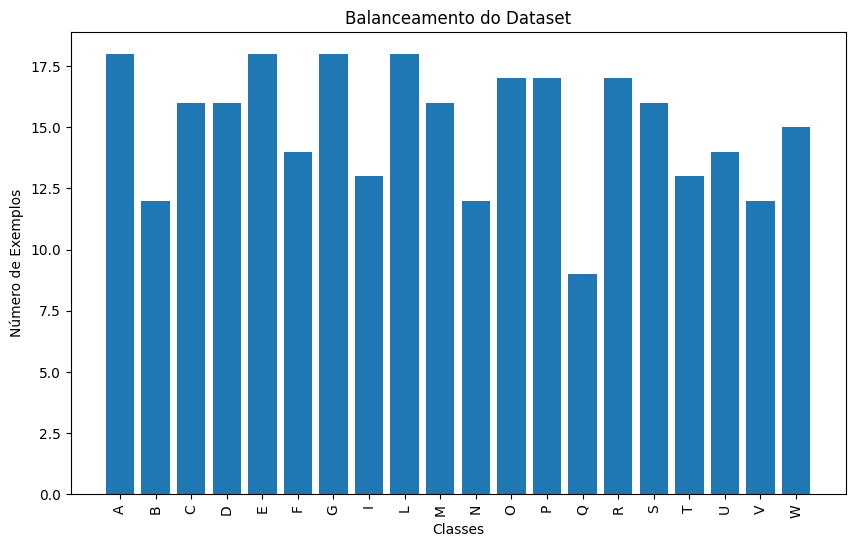

In [5]:
import os
import matplotlib.pyplot as plt

classes = os.listdir("/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/")
class_count = {classe: 0 for classe in classes}


for image in os.listdir(f"/media/emanueloliveira/Dados/SCC0910ComputerVision/Nosso Dataset/"):
    classe = image[0].upper()
    if classe in class_count:
        class_count[classe] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_count.keys(), class_count.values())
plt.xlabel("Classes")
plt.ylabel("Número de Exemplos")
plt.title("Balanceamento do Dataset")
plt.xticks(rotation='vertical')
plt.show()